# Машинное обучение, DS-поток, осень 2024
## Задание ML.9

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Правила оформления теоретических задач:**

В задании требуется вывести формулы для обратного прохода.
* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов

**Баллы за задание**  
    1. Простая нейронная сеть &mdash; **40 баллов**  
    2. BatchNorm &mdash; **80 баллов**  
    3. Dropout &mdash; **50 баллов**  
    4. Регуляризация весов &mdash; **30 баллов**  
    5. Затухание градиента &mdash; **40 баллов**  
    6. Выводы &mdash; **10 баллов**  
    
 Всего &mdash;   **250 баллов**.

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
sns.set_style('darkgrid')

from torchvision.datasets import FashionMNIST
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
from collections import defaultdict
import numpy as np
import time
from IPython.display import clear_output

In [163]:
# Bot check

# HW_ID: ds_ml9
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.


В данном задании вам предстоит проверить на практике эффективность методов, представленных на лекции на одном из базовых датасетов для нейронных сетей. Естественно, обобщать наблюдения нельзя, но некоторые тенденции вы сможете заметить.

**Совет**

Это задание будет быстрее выполнить на GPU. Чтобы не тратить много времени на GPU (важно на Google Colab), **проверяйте работоспособность кода на CPU на маленьком объеме данных**, где это возможно, а затем переходите на GPU.

In [164]:
device = torch.device('cpu')  # автоматическй выбор девайса
if torch.cuda.is_available():
    device = torch.device('cuda')

### 0. Данные
Будем использовать набор данных **Fasion MNIST**. Скачаем тренировочный и тестовый наборы данных.

In [165]:
train_source = FashionMNIST('fasionmnist', download=True, train=True)
test_source = FashionMNIST('fasionmnist', download=True, train=False)

Он содержит 60 000 изображений в тренировочной части данных и 10 000 в тестовой.

In [166]:
len(train_source.data), len(test_source.data)

(60000, 10000)

In [167]:
train_source.data.shape  # ч\б картинки 28x28

torch.Size([60000, 28, 28])

В датасете содержится 10 классов одежды.

In [168]:
train_source.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Можно посмотреть их названия.

In [169]:
train_source.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Проиллюстрируем набор данных.

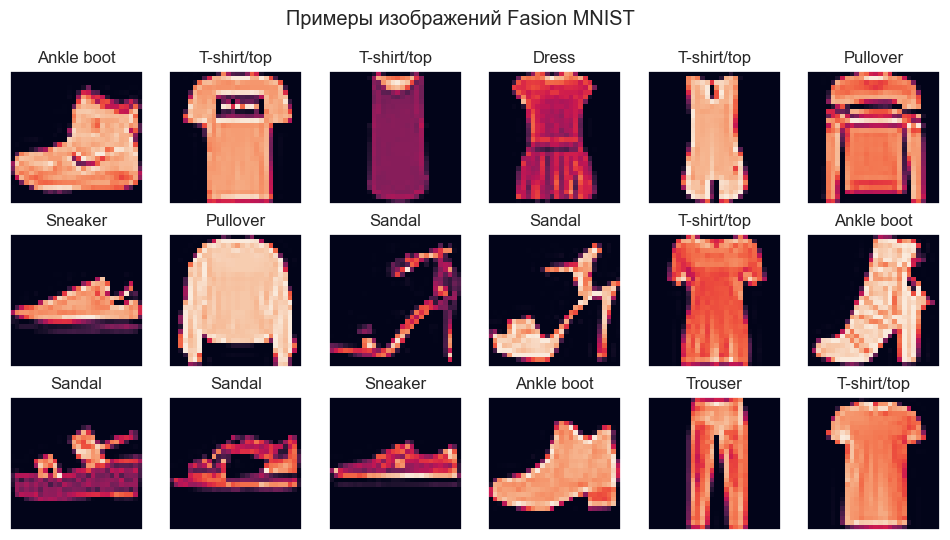

In [170]:
fig, axs = plt.subplots(3, 6, figsize=(12, 6))
for k, (image, label) in enumerate(zip(train_source.data[:18], train_source.targets[:18])):
    i, j = k // 6, k % 6
    axs[i][j].imshow(image)
    axs[i][j].grid()
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    axs[i][j].set_title(train_source.classes[label])
fig.suptitle('Примеры изображений Fasion MNIST')
plt.show()

In [171]:
X_train, y_train, X_val, y_val = train_source.data, train_source.targets, test_source.data, test_source.targets  # для удобства

### 1. Простая полносвязная нейронная сеть

Сначала вспомним функцию обучения модели, которую мы уже много раз использовали.

In [ ]:
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs, device, checkpoint_path=None):
    """Обучение модели"""
    start_time = time.time()
    history = defaultdict(lambda: defaultdict(list))
    best_val_acc = 0.
    model.to(device)
    
    for epoch in range(num_epochs):
        train_loss, train_acc, val_loss, val_acc, train_size, val_size = 0, 0, 0, 0, 0, 0
        
        model.train()  # поведение dropout / batch_norm -> обучение
        for X_batch, y_batch in train_loader:  # на каждой эпохе - полный проход по данным
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)  # обучаемся на батче (одна итерация обучения нейросети)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach() * len(y_batch)
            y_pred = torch.argmax(logits, dim=1).detach()
            train_acc += (y_pred==y_batch).sum()
            train_size += X_batch.size(0)
        train_loss = train_loss.cpu().numpy() / train_size  # считаем лоссы и точность, сохраняем в историю
        train_acc = train_acc.cpu().numpy() / train_size
        history['Лосс']['train'].append(train_loss)
        history['Акьюраси']['train'].append(train_acc)

        model.eval()  # поведение dropout / batch_norm -> тестирование
        with torch.no_grad():  # полный проход по валидации (аналогично трейну, но без градиентов)
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                logits = model(X_val_batch)
                loss = criterion(logits, y_val_batch)
                val_loss += loss * len(y_batch)
                y_pred = torch.argmax(logits, dim=1)
                val_acc += (y_pred==y_val_batch).sum()
                val_size += X_val_batch.size(0)
        val_loss = val_loss.cpu().numpy() / val_size  # считаем лоссы и точность, сохраняем в историю
        val_acc = val_acc.cpu().numpy() / val_size
        history['Лосс']['val'].append(val_loss)
        history['Акьюраси']['val'].append(val_acc)

        if (checkpoint_path is not None) and (val_acc > best_val_acc):  # сохраняем лучшую модель по метрике на валидации
            torch.save({'model': model.state_dict(), 'optim': optimizer.state_dict()}, checkpoint_path)
            best_val_acc = val_acc
        clear_output()  # печатаем результаты после каждой эпохи (заменил на f-строки)
        print(f"Epoch {epoch+1} of {num_epochs}. Total time {time.time()-start_time:.3f}s")
        print(f"  training loss (in-iteration): \t{train_loss:.6f}")
        print(f"  validation loss (in-iteration): \t{val_loss:.6f}")
        print(f"  training accuracy: \t\t\t{train_acc*100:.2f} %")
        print(f"  validation accuracy: \t\t\t{val_acc*100:.2f} %")

    return history

Постройте простую полносвязную двухслойную нейронную сеть с функцией активации ReLU. Обучите ее на тренировочной части данных. Можете использовать `SimpleDataset()` из семинара. Используйте кросс-энтропию в качестве функции ошибки. Добейтесь хотя бы 0.87 accuracy на тестовой части данных.

In [ ]:
model = nn.Sequential(
    nn.Linear(1*28*28, 1024),  # вход: ч\б картинки 28x28
    nn.ReLU(),
    nn.Linear(1024, 10),  # выход: 10 классов
).to(device)

In [ ]:
class Dataset():
    def __init__(self, X_data, y_data):
        self.x, self.y = X_data, y_data
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx].float().ravel(), self.y[idx]

batch_size, num_workers, num_epochs = 32, 2, 40
train_dataset, val_dataset = Dataset(X_train, y_train), Dataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)  # lr = Karpathy const)
history = train(model, criterion, optimizer, train_loader, val_loader, num_epochs, device, checkpoint_path=None)

Epoch 4 of 4. Total time 0.045s
  training loss (in-iteration): 	0.000000
  validation loss (in-iteration): 	71.524269
  training accuracy: 			100.00 %
  validation accuracy: 			25.00 %


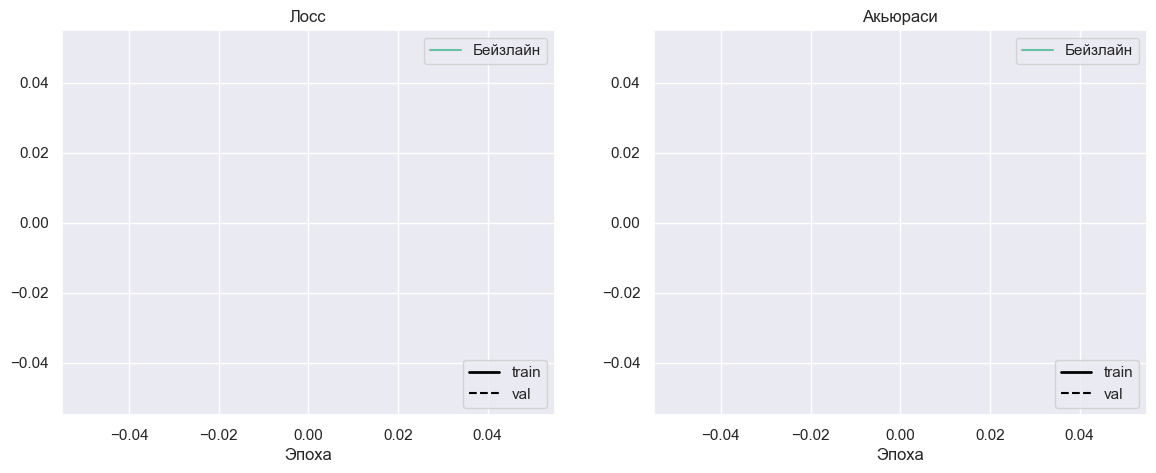

In [301]:
def plot_histories(histories, names):  
    """Отрисовка кривых обучения"""
    _, axs = plt.subplots(1, 2, figsize=(14, 5))
    epochs = np.min([len(h['Лосс']['train']) for h in histories])
    for history, name in zip(histories, names):
        for ax, key in zip(axs, ['Лосс','Акьюраси']):
            ax.set_title(key)
            ax.plot(history[key]['train'][:epochs], label=name)
            ax.plot(history[key]['val'][:epochs], ls='--')
            ax.set_xlabel('Эпоха')
        axs[1].legend()
    dummy_lines = [axs[0].plot([], [], c='black', lw=2)[0], axs[0].plot([], [], c='black', ls='--')[0]]
    for ax in axs:
        legend = ax.legend(loc=3-i)
        ax.legend(dummy_lines, ["train", "val"], loc=4)
        ax.add_artist(legend)
    
plot_histories([history], ['Бейзлайн'])

Визуализируйте "вероятности" предсказанных моделью классов для нескольких изображений из теста. Для этого нужно применить SoftMax к выходам модели.

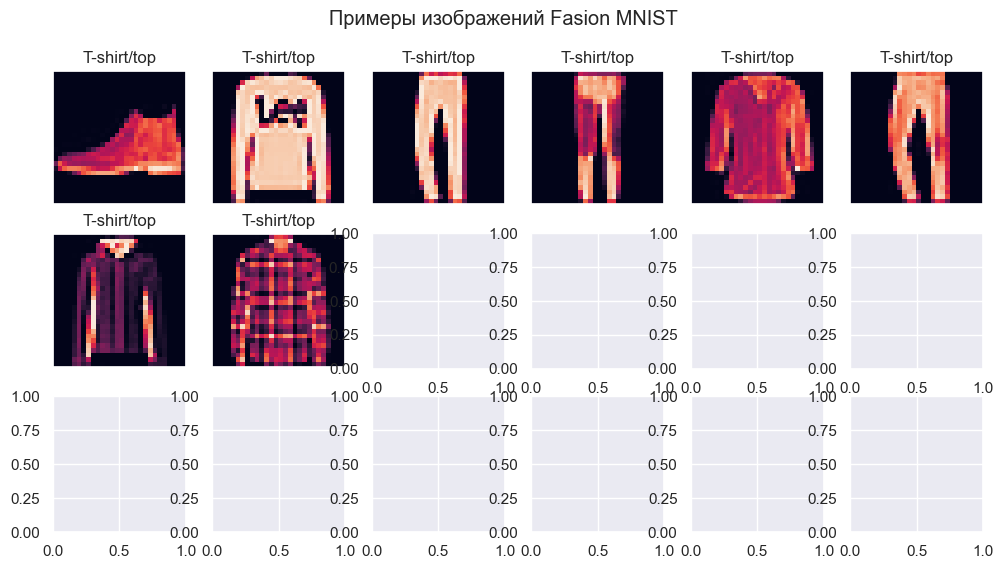

In [ ]:
def plot_confs(model):
    """Визуализация предикто на тесте"""
    loader = DataLoader(val_dataset, 18, shuffle=False, num_workers=num_workers)  # для показа
    model.eval()
    with torch.no_grad():  # возьмем 1 батч удобного для показа размера
        X_val_batch, _ = [t.to(device) for t in next(iter(loader))]
        images = X_val_batch.cpu().numpy().reshape((18,28,28))
        pred = model(X_val_batch)
        y_preds = torch.argmax(pred, dim=1).cpu().numpy()
        y_confs = torch.max(nn.functional.softmax(pred, dim=1)).cpu().numpy()

    fig, axs = plt.subplots(3, 6, figsize=(12, 6))
    for k, (image, y_pred, y_conf) in enumerate(zip(images, y_preds, y_confs)):
        i, j = k // 6, k % 6
        axs[i][j].imshow(image)
        axs[i][j].grid()
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].set_title(f'{train_source.classes[y_pred]} (p={y_conf})')
    fig.suptitle('Предикты на Fasion MNIST')
    plt.show()

plot_confs(model)

### 2. BatchNorm

Проверьте два варианта включения BatchNorm в архитектуру двухслойной сети: до функции активации и после нее. В итоге получается 2 модели:
```
(1) Linear -> BatchNorm -> ReLU -> Linear
(2) Linear -> ReLU -> BatchNorm -> Linear
```
Обучите обе модели. Постройте графики распределений выходов первого, второго и третьего слоя сети (т.е. всех кроме последнего) для каждой модели до обучения, в процессе обучения и после обучения. Сравните эти графики с соответствующими графиками модели без BatchNorm. В этом пункте все графики распределений лучше строить с помощью `kdeplot`.

In [ ]:
models = {
    # модель без батч-нормализации
    'no_bn': nn.Sequential(nn.Linear(1*28*28, 1024), nn.ReLU(), nn.Linear(1024, 10)).to(device),
    # модели с батч-нормализацией
    'bn_relu': nn.Sequential(nn.Linear(1*28*28, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Linear(1024, 10)).to(device),
    'relu_bn': nn.Sequential(nn.Linear(1*28*28, 1024), nn.ReLU(), nn.BatchNorm1d(1024), nn.Linear(1024, 10)).to(device),
}

In [ ]:
# def calc_outputs(model, device):  # по-моему, тут опечатка, и имелся в виду не девайс, а инпут
#     '''Считает выходы модели после 1, 2 и 3 слоев. Возвращает 3 тензора.'''        
#     return <...>

layers = ['l1','l2','l3']

def calc_outputs(model, X):
    '''Считает выходы модели после 1, 2 и 3 слоев. Возвращает 3 тензора.'''  
    # в задаче не очень понятно, но видимо, нужно прогнать на всей валидации
    model.eval()
    outputs = {l:[] for l in layers}
    with torch.no_grad():
        submodels = [nn.Sequential(*list(model.children())[:c]) for c in range(1,4)]
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            for l,m in zip(layers, submodels):
                outputs[l] = m(X_val_batch).flatten()
    return outputs

Будем записывать выходы модели в `outputs`.

In [291]:
outputs = {name: {l:{} for l in layers} for name in ('no_bn', 'bn_relu', 'relu_bn')}

In [292]:
# train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers)
# val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers)
# criterion = nn.CrossEntropyLoss()

for model_name, model in models.items():
    optimizer = optim.AdamW(model.parameters(), lr=3e-4)
    for k,v in calc_outputs(model, X_val).items():  # выходы слоев перед обучением
        outputs[model_name][k]['init'] = v 
    train(model, criterion, optimizer, train_loader, val_loader, num_epochs=20, device=device, checkpoint_path=None)
    for k,v in calc_outputs(model, X_val).items():  # выходы слоев во время обучения
        outputs[model_name][k]['train'] = v
    train(model, criterion, optimizer, train_loader, val_loader, num_epochs=20, device=device, checkpoint_path=None)
    for k,v in calc_outputs(model, X_val).items():  # выходы слоев после обучения модели
        outputs[model_name][k]['final'] = v

Epoch 20 of 20. Total time 0.239s
  training loss (in-iteration): 	0.085214
  validation loss (in-iteration): 	21.670132
  training accuracy: 			100.00 %
  validation accuracy: 			12.50 %


C:\Users\aikru\AppData\Local\Temp\ipykernel_5384\2370552715.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


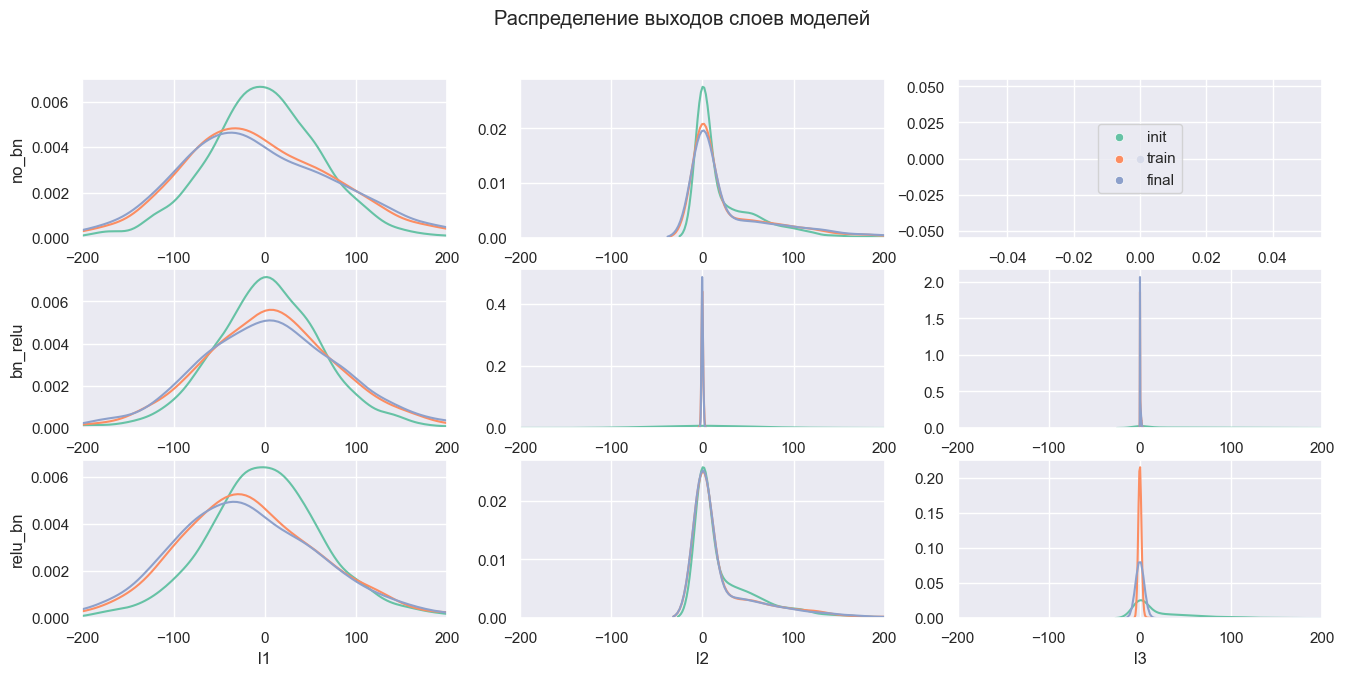

In [293]:
fig, axs = plt.subplots(3, 3, figsize=(16,7))
for i, model_name in enumerate(models.keys()):
    for j, layer in enumerate(layers):
        
        if model_name=='no_bn' and layer=='l3':   # у no_bn на 1 слой меньше, а последний слой не интересен. Там поместим легенду
            for stage in ['init', 'train', 'final']:
                sns.scatterplot(x=[0], y=[0], label=stage, ax=axs[i][j])
            axs[i][j].legend(loc='center')
            continue

        for stage in ['init', 'train', 'final']:
            sns.kdeplot(outputs[model_name][layer][stage], ax=axs[i][j])
            axs[i][j].set_xlim((-200,200))
            axs[i][j].set_ylabel(model_name if layer=='l1' else '')
            axs[i][j].set_xlabel(layer if model_name=='relu_bn' else '')

fig.suptitle('Распределение выходов слоев моделей')
fig.show()

**Вывод:** ...  !!!!!!!

Обучите оба варианта модели с BatchNorm с разными инициализациями хотя бы 3 раза. Инициализации должны отличаться только random state. Сравните качество моделей по loss и accuracy в зависимости от номера итерации.

Epoch 40 of 40. Total time 0.277s
  training loss (in-iteration): 	0.008277
  validation loss (in-iteration): 	77.713791
  training accuracy: 			100.00 %
  validation accuracy: 			25.00 %


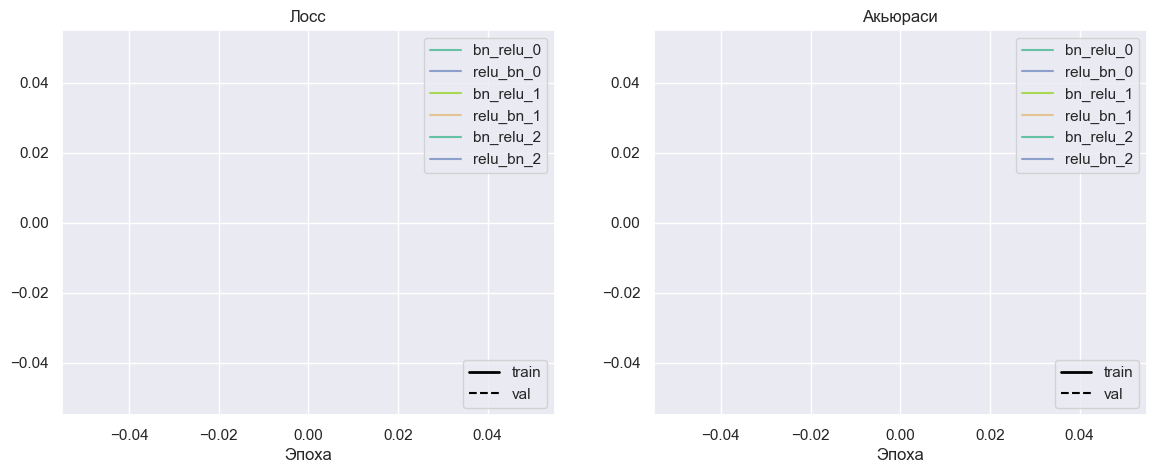

In [ ]:
histories, experiments = [], []
for seed in range(3):
    torch.manual_seed(seed)
    # torch.manual_seed_all(seed)
    models = {
        'bn_relu': nn.Sequential(nn.Linear(1*28*28, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Linear(1024, 10)).to(device),
        'relu_bn': nn.Sequential(nn.Linear(1*28*28, 1024), nn.ReLU(), nn.BatchNorm1d(1024), nn.Linear(1024, 10)).to(device),
    }
    for model_name, model in models.items():
        for name, param in model.named_parameters():
            try:
                param.data = nn.init.kaiming_uniform_(param.data, nonlinearity='relu')
            except:
                pass
        optimizer = optim.AdamW(model.parameters(), lr=3e-4)
        histories.append(train(model, criterion, optimizer, train_loader, val_loader, num_epochs=40, device=device, checkpoint_path=None))
        experiments.append(f'{model_name}_{seed}')

plot_histories(histories, experiments)

Выберите лучшую обученную модель с BatchNorm. Посмотрите на распределение выходов слоя до BatchNorm и самого BatchNorm для нескольких батчей из тестовой части данных. Согласуются ли результаты с утверждением, что BatchNorm решает проблему ковариантного сдвига для батчей?



In [ ]:
!!!!!!!!!!!!!!

**Ответ:** ...

### 3. Dropout
Для начала добьемся переобучения модели. Это можно сделать, если использовать больше параметров в слое, дольше обучать или поменять параметры оптимизатора. Например, так:

In [ ]:
model = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-3,
)
DO_histories = []
DO_histories.append(
    train(
        model,
        criterion,
        optimizer,
        train_loader,
        test_loader,
        num_epochs=60,
        device=device,
    )
)

In [ ]:
plot_histories(DO_histories, ['модель с переобуч.'])

Добавьте Dropout в модель. Сравните скорость обучения и качество моделей в зависимости от параметра $p$ в Dropout.

Измерьте, насколько переобучаются модели в каждом случае - для этого посчитайте среднюю разность лосса на валидации и трейне (со знаком) на последних 10 или 20 эпохах.

**Вывод:** ...

### 4. Регуляризация весов
Проверьте распределение весов переобученной модели в пункте 3. Попробуйте добиться такого эффекта переобучения, при котором возникают большие значения некоторых весов. Даже если не получится, нужно показать, что вы пытались ;)

Примените L2-регуляризацию при обучении модели. Для этого нужно указать коэффициент регуляризации через параметр `weight_deacay` в оптимизаторе. Напоминаем, если вы хотите использовать `Adam`, то его нужно поменять на `AdamW`, так как в `Adam` регуляризация реализована не совсем корректно. Покажите, что проблема больших весов решается.

**Вывод:** ...

### 5. Затухание градиента

Продемонстрируем эффект затухания градиента. Для этого будем визуализировать долю градиентов близких к нулю на каждом слое в течение обучения. Добавим в функцию обучения подсчет доли околонулевых градиентов:

In [ ]:
def train_count_zero_grads(
        model,
        criterion,
        optimizer,
        train_loader,
        val_loader,
        num_epochs,
        device,
        checkpoint_path=None,
):
    """
    # Обучение модели
    """
    start_time = time.time()
    history = defaultdict(lambda: defaultdict(list))
    best_val_acc = 0.
    model.to(device)

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        train_size, val_size = 0, 0

        model.train()  # устанавливаем поведение dropout / batch_norm в обучение
        zero_grads = defaultdict(float) # количество околонулевых градиентов
        n_grads = defaultdict(int) # количество градиентов всего

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            logits = <...>
            loss = <...>

            for name, param in model.named_parameters():
                # Будем считать градиент околонулевым, если его модуль меньше 1e-5
                zero_grads[name] += <...>
                n_grads[name] += <...>

            train_loss += <...>
            y_pred = <...>
            train_acc += <...>
            train_size += <...>

        # Подсчитываем лоссы и точность, сохраням в "историю"
        train_loss = train_loss.cpu().numpy() / train_size
        train_acc = train_acc.cpu().numpy() / train_size
        history['Лосс']['train'].append(train_loss)
        history['Акьюраси']['train'].append(train_acc)
        for name, _ in model.named_parameters():
            mean_zero_grads = zero_grads[name] / n_grads[name]
            history['grad'][name].append(mean_zero_grads)

        # Устанавливаем поведение dropout / batch_norm  в тестирование
        model.eval()

        # Полный проход по валидации
        <...>

        # Подсчитываем лоссы и сохраням в "историю"
        <...>

        # Сохраняем лучшую модель по метрике на валидации
        if (checkpoint_path is not None) and (val_acc > best_val_acc):
            torch.save({
                'model': model.state_dict(),
                'optim': optimizer.state_dict(),
                }, checkpoint_path)
            best_val_acc = val_acc

        clear_output()
        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {}. Total time {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

    return history

Постройте более глубокую сеть, в качестве функций активации используйте гиперболический тангенс. Визуализируйте долю градиентов близких к нулю на каждом слое в течение обучения.

Попробуйте решить задачу затухания градиента с помощью использования функции активации LeakyReLU.

### Выводы
Обобщите результаты проведенных экспериментов.